In [1]:
# Required Imports
import os, json, time
from pyproj import Transformer, Geod    
from wildfire.Reader import Reader as WFReader
import geojson
import pandas as pd
import matplotlib.pyplot as plt

/var/folders/js/_m5r698x29j4dvr0w18h6jdm0000gn/T/ipykernel_13299/3262185334.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
with open('intermediate_file_paths.json') as output_path_file:
    output_paths = json.load(output_path_file)

SI_PER_FIRE_INPUT_PATH = output_paths.get('stage1_si_per_fire_csv')
SI_PER_YEAR_INPUT_PATH = output_paths.get('stage1_si_per_year_csv')
EPA_AQI_PER_YEAR_INPUT_PATH = output_paths.get('stage1_epa_aqi_per_year_csv')
FIRE_INPUT_PATH = output_paths.get('stage0_fire_json')


SCALED_SI_PER_YEAR_OUTPUT_PATH = output_paths.get('stage2_scaled_si_per_year_csv')

## Question 1

In [62]:
with open(FIRE_INPUT_PATH) as fire_file:
    fire_data_for_hist = geojson.load(fire_file)

In [63]:
fire_distances = []

for feature in fire_data_for_hist['features']:

    dist_from_memphis = feature.get('attributes', {}).get('distance')
    fire_distances.append(dist_from_memphis)

In [64]:
# Convert fire_distances to a DataFrame for easier analysis and plotting
distances_df = pd.DataFrame(fire_distances, columns=['distance_miles'])

# Calculate summary statistics
distance_summary = distances_df['distance_miles'].describe()
print("Distance Summary Statistics:")
print(distance_summary)

Distance Summary Statistics:
count    101906.000000
mean       1059.860947
std         526.912300
min           5.992876
25%         572.452124
50%        1127.416618
75%        1561.397625
max        1799.999235
Name: distance_miles, dtype: float64


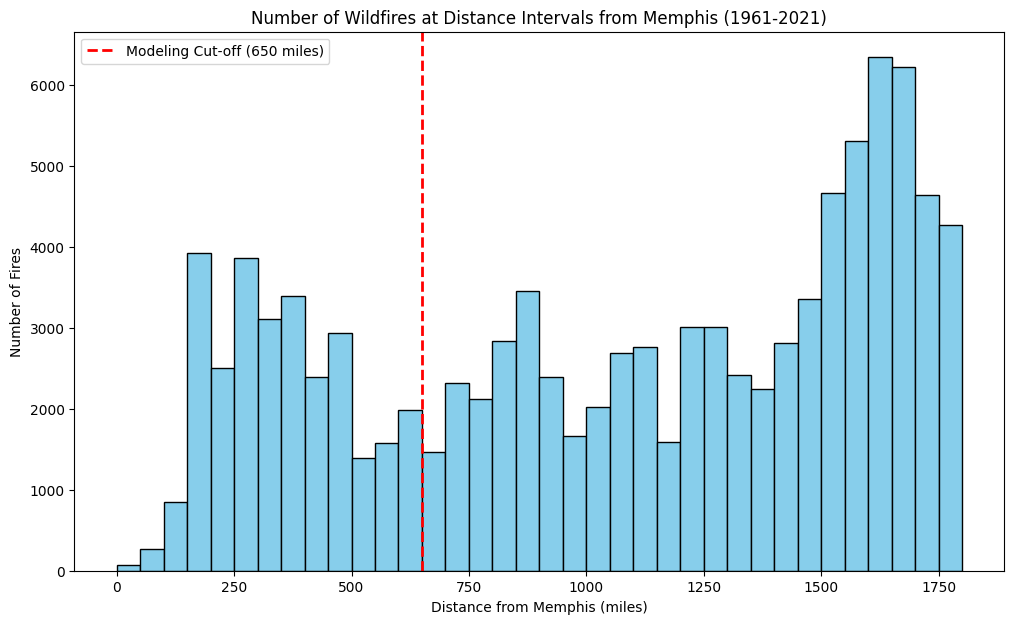

In [65]:
# Define the bin edges for every 50-mile interval up to 1800 miles
bins = list(range(0, 1801, 50))  # Creates bins: 0-50, 50-100, ..., up to 1750-1800

# Set the distance cut-off for modeling (replace with your specific cut-off if different)
modeling_distance_cutoff = 650

# Plot the histogram
plt.figure(figsize=(12, 7))
plt.hist(fire_distances, bins=bins, color='skyblue', edgecolor='black')
plt.axvline(x=modeling_distance_cutoff, color='red', linestyle='--', linewidth=2, label=f'Modeling Cut-off ({modeling_distance_cutoff} miles)')
plt.xlabel('Distance from Memphis (miles)')
plt.ylabel('Number of Fires')
plt.title('Number of Wildfires at Distance Intervals from Memphis (1961-2021)')
plt.legend()
plt.show()

## Question 2

In [3]:
per_year_df = pd.read_csv(SI_PER_YEAR_INPUT_PATH)

In [4]:
# Display the column headers and basic information for the politician dataset
print("\nPer Year Smoke Imact + Acres Burned - Column Headers:")
print(per_year_df.columns)

print("\nPer Year Smoke Imact + Acres Burned - Basic Info:")
print(per_year_df.info())

print("\nPer Year Smoke Imact + Acres Burned - First 5 Rows:")
print(per_year_df.head())


Per Year Smoke Imact + Acres Burned - Column Headers:
Index(['fire_year', 'total_amortized_smoke_impact', 'total_fire_duration',
       'total_acres_burned', 'avg_daily_smoke_impact'],
      dtype='object')

Per Year Smoke Imact + Acres Burned - Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   fire_year                     57 non-null     int64  
 1   total_amortized_smoke_impact  57 non-null     float64
 2   total_fire_duration           57 non-null     float64
 3   total_acres_burned            57 non-null     float64
 4   avg_daily_smoke_impact        57 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 2.4 KB
None

Per Year Smoke Imact + Acres Burned - First 5 Rows:
   fire_year  total_amortized_smoke_impact  total_fire_duration  \
0       1964                  7.432192e-07         

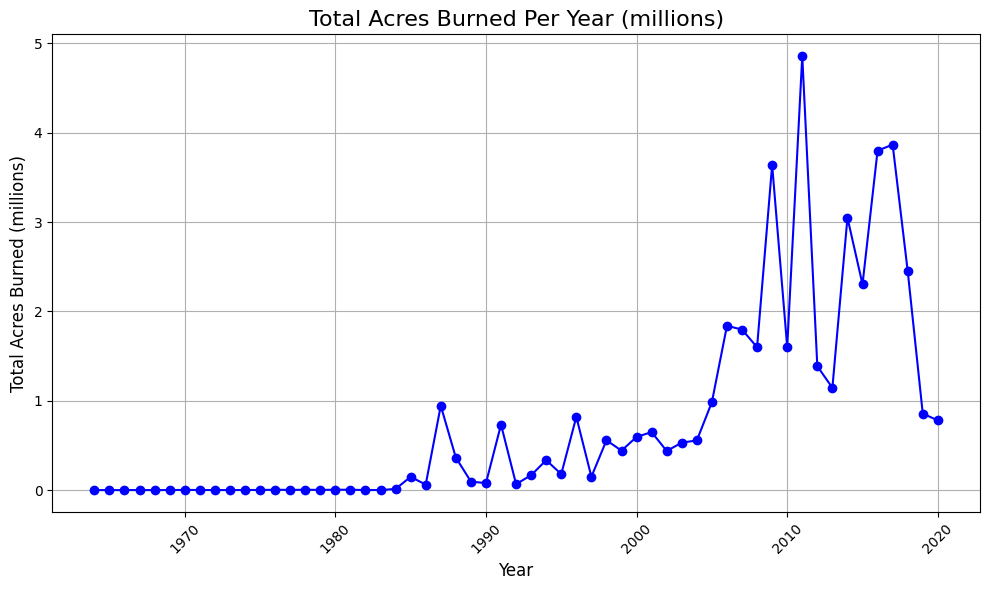

In [5]:
# Convert total acres burned to millions
per_year_df['total_acres_burned_millions'] = per_year_df['total_acres_burned'] / 1e6


# Plotting the time series of total acres burned per year in millions
plt.figure(figsize=(10, 6))

# Plot total acres burned (in millions) against the year
plt.plot(per_year_df['fire_year'], per_year_df['total_acres_burned_millions'], marker='o', linestyle='-', color='b')

# Adding title and labels
plt.title('Total Acres Burned Per Year (millions)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Acres Burned (millions)', fontsize=12)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()


## Question 3

In [87]:
epa_aqi_df = pd.read_csv(EPA_AQI_PER_YEAR_INPUT_PATH)

print(epa_aqi_df.head(5))

   year  site_code              site_name  pollutant_number   pollutant_name  \
0  1972         21  Frayser Ozone Monitor             44201            Ozone   
1  1973         21  Frayser Ozone Monitor             42101  Carbon monoxide   
2  1973         21  Frayser Ozone Monitor             44201            Ozone   
3  1973         24   Alabama Ave. Station             42101  Carbon monoxide   
4  1973         24   Alabama Ave. Station             44201            Ozone   

   average_aqi_fire_season  
0                16.250000  
1                36.536585  
2                40.333333  
3                58.622951  
4                18.781250  


In [88]:
annual_aqi_per_year_df = epa_aqi_df.groupby('year', as_index=False)['average_aqi_fire_season'].mean()

In [89]:
si_per_year_df = pd.read_csv(SI_PER_YEAR_INPUT_PATH)

print(si_per_year_df.columns)

Index(['fire_year', 'total_amortized_smoke_impact', 'total_fire_duration',
       'total_acres_burned', 'avg_daily_smoke_impact'],
      dtype='object')


In [90]:
scaling_factor = 10000000

# Apply scaling to bring avg_daily_smoke_impact to a 0-500 range
si_per_year_df['scaled_avg_daily_smoke_impact'] = (
    si_per_year_df['avg_daily_smoke_impact'] * scaling_factor
)

# Display the results
print(si_per_year_df[['fire_year', 'avg_daily_smoke_impact', 'scaled_avg_daily_smoke_impact']].head(5))

   fire_year  avg_daily_smoke_impact  scaled_avg_daily_smoke_impact
0       1964            7.430301e-08                       0.743030
1       1965            3.939202e-08                       0.393920
2       1966            3.440880e-08                       0.344088
3       1967            5.019618e-07                       5.019618
4       1968            3.645253e-08                       0.364525


In [77]:
all_years = pd.DataFrame({'year': range(2021 - 60, 2022)})

# Fill in missing years with 0 values, focusing only on the necessary columns
si_per_year_df = all_years.merge(si_per_year_df, how='left', left_on='year', right_on='fire_year').fillna({'scaled_smoke_impact': 0})
annual_aqi_per_year_df = all_years.merge(annual_aqi_per_year_df, how='left', on='year').fillna({'average_aqi_fire_season': 0})

# Get the number of records after the merge
yearly_smoke_impact_count = len(si_per_year_df )
annual_aqi_per_year_count = len(annual_aqi_per_year_df)
all_years_count = len(all_years)

print(f"Number of records in yearly_smoke_impact_df after merge: {yearly_smoke_impact_count}")
print(f"Number of records in annual_aqi_per_year_df after merge: {annual_aqi_per_year_count}")
print(f"Number of records in all_years after merge: {all_years_count }")

Number of records in yearly_smoke_impact_df after merge: 61
Number of records in annual_aqi_per_year_df after merge: 61
Number of records in all_years after merge: 61


In [ ]:
# Save per-year data to CSV
si_per_year_df.to_csv(SCALED_SI_PER_YEAR_OUTPUT_PATH, index=False)

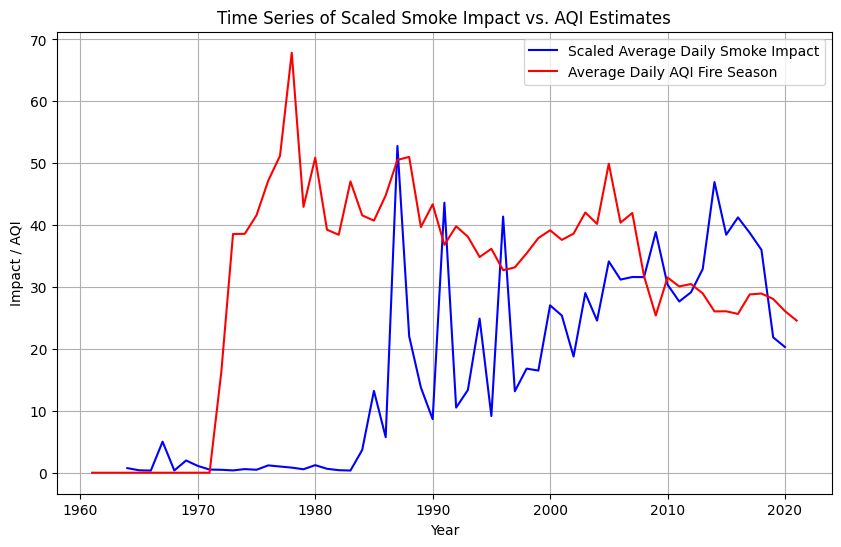

In [78]:
# Plotting the time series comparison
plt.figure(figsize=(10, 6))
plt.plot(si_per_year_df['fire_year'], si_per_year_df['scaled_avg_daily_smoke_impact'], label='Scaled Average Daily Smoke Impact', color='blue')
plt.plot(annual_aqi_per_year_df['year'], annual_aqi_per_year_df['average_aqi_fire_season'], label='Average Daily AQI Fire Season', color='red')
plt.xlabel('Year')
plt.ylabel('Impact / AQI')
plt.title('Time Series of Scaled Smoke Impact vs. AQI Estimates')
plt.legend()
plt.grid(True)
plt.show()

### Additional Graphs

In [ ]:
si_per_fire_df = pd.read_csv(SI_PER_FIRE_INPUT_PATH)
print(si_per_fire_df.columns)

Index(['OBJECTID', 'USGS_Assigned_ID', 'Assigned_Fire_Type', 'fire_year',
       'Fire_Polygon_Tier', 'Fire_Attribute_Tiers', 'total_acres_burned',
       'GIS_Hectares', 'Source_Datasets', 'Listed_Fire_Types',
       'Listed_Fire_Names', 'Listed_Fire_Codes', 'Listed_Fire_IDs',
       'Listed_Fire_IRWIN_IDs', 'Listed_Fire_Dates', 'Listed_Fire_Causes',
       'Listed_Fire_Cause_Class', 'Listed_Rx_Reported_Acres',
       'Listed_Map_Digitize_Methods', 'Listed_Notes', 'Processing_Notes',
       'Wildfire_Notice', 'Prescribed_Burn_Notice', 'Wildfire_and_Rx_Flag',
       'Overlap_Within_1_or_2_Flag', 'Circleness_Scale', 'Circle_Flag',
       'Exclude_From_Summary_Rasters', 'Shape_Length', 'Shape_Area',
       'distance', 'smoke_impact', 'fire_duration', 'amortized_smoke_impact'],
      dtype='object')


   fire_year  num_fires
0       1964          1
1       1965          3
2       1966          3
3       1967          3
4       1968          3


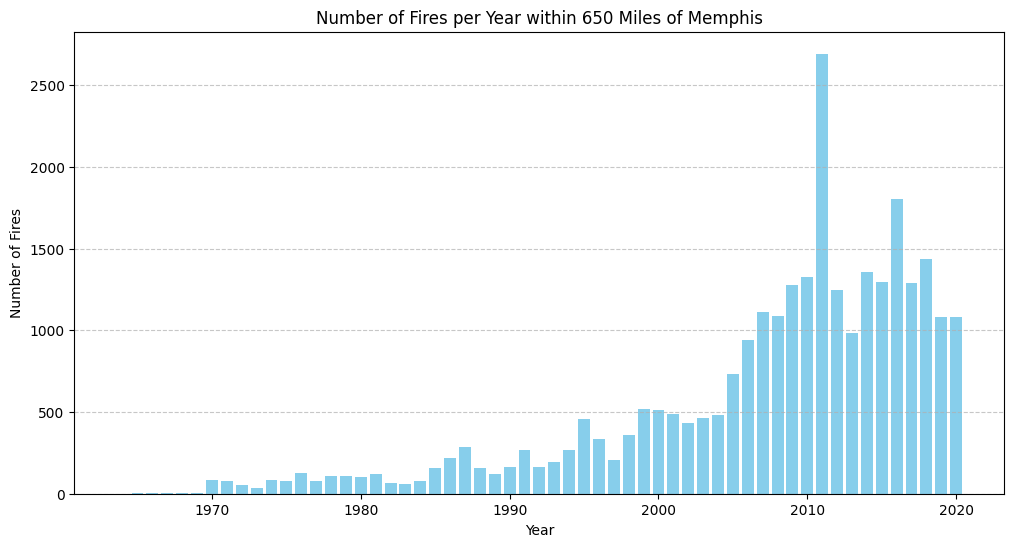

In [ ]:
# # Calculate the number of fires per year within the 650-mile radius of Memphis
fires_per_year_df = si_per_fire_df.groupby('fire_year').size().reset_index(name='num_fires')

# print(fires_per_year_df.head(5))

# Plot the number of fires per year
plt.figure(figsize=(12, 6))
plt.bar(fires_per_year_df['fire_year'], fires_per_year_df['num_fires'], color='skyblue')
plt.title('Number of Fires per Year within 650 Miles of Memphis')
plt.xlabel('Year')
plt.ylabel('Number of Fires')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()